In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
from PIL import Image
import urllib

In [2]:
chromedriver_autoinstaller.install()

'/Users/joewilliamson/opt/anaconda3/envs/dataAnalysis/lib/python3.9/site-packages/chromedriver_autoinstaller/110/chromedriver'

In [3]:
if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640737/Live/England-Premier-League-2022-2023-Fulham-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640737


/Users/joewilliamson/Python/Football Analytics/Whoscored Data/main.py:471: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  events_df[event_type] = pd.Series([event_type in row for row in list(events_df['satisfiedEventsTypes'])])


## Colours 

In [4]:
home_color = '#9C9C9C'
away_color = '#2D5DE7'

In [5]:
homeID = home_data['teamId']
awayID = away_data['teamId']

## Carries 

In [6]:
df_carries = pd.DataFrame()
min_len = 3
max_len = 60
min_time = 1
max_time = 12

for idx, match_event in events_df.iterrows():
    if idx == len(events_df) - 1:
        break
    
    cur_team = match_event['teamId']
    idx_next = idx + 1
    events_df_next = events_df.loc[idx_next]
    take_ons = 0
    loop = True
    count = 0 
    
    while loop:
        next_events = events_df.loc[idx_next]
        
        if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
            take_ons += 1
            loop = True
        
        elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
            loop = True
            
        else:
            loop = False
            
        idx_next += 1
        count += 0 
        

    same_team = cur_team == next_events['teamId']
    not_ball_touch = match_event['type'] != 'BallTouch'
    dx = 105 * (match_event['endX'] - next_events['x'])/100
    dy = 68 * (match_event['endY'] - next_events['y'])/100
    min_dist = dx**2 + dy**2 >= min_len**2
    max_dist = dx**2 + dy**2 <= max_len**2
    same_period = match_event['period'] == next_events['period']
    
    valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 
    
    if valid_carry:
        carry = pd.DataFrame()
        prev = match_event
        nxt = next_events
        carry.loc[0, 'eventId'] = prev['eventId'] + count
        carry['id'] = prev['id'] + count
        carry['teamId'] = nxt['teamId']
        carry['x'] = prev['endX']
        carry['y'] = prev['endY']
        carry['period'] = nxt['period']
        carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
        carry['outcomeType'] = 'Successful'
        carry['qualifiers'] = carry.apply(
            lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
        carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
        carry['isTouch'] = True
        carry['playerId'] = nxt['playerId']
        carry['playerName'] = nxt['playerName']
        carry['endX'] = nxt['x']
        carry['endY'] = nxt['y']
        
        df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)


In [7]:
df_carries

,eventId,id,teamId,x,y,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,playerName,endX,endY
0,7.0,2.496789e+09,15,18.9,74.1,FirstHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,90880,Kalidou Koulibaly,25.3,69.6
1,8.0,2.496789e+09,15,19.3,47.8,FirstHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,28550,Thiago Silva,25.5,53.1
2,9.0,2.496789e+09,15,34.0,78.5,FirstHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,90880,Kalidou Koulibaly,39.6,81.8
3,11.0,2.496789e+09,15,43.7,67.8,FirstHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,252419,Denis Zakaria,43.8,75.0
4,15.0,2.496789e+09,15,34.9,93.3,FirstHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,252419,Denis Zakaria,29.9,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,883.0,2.496811e+09,15,14.1,39.7,SecondHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,28550,Thiago Silva,18.2,39.8
233,891.0,2.496811e+09,15,24.0,59.4,SecondHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,375621,Conor Gallagher,18.9,49.0
234,850.0,2.496811e+09,170,46.9,68.7,SecondHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,322774,João Palhinha,43.8,69.6
235,909.0,2.496811e+09,15,53.2,66.2,SecondHalf,"{'value': 99, 'displayName': 'Carry'}",Successful,"{'type': {'value': 999, 'displayName': 'takeOn...",[],True,375621,Conor Gallagher,48.8,66.2


## Box Passes 

In [8]:
box_passes_h = events_df[(events_df['teamId'] == homeID) & 
                         (events_df['type'] == 'Pass') & 
                         (events_df['outcomeType'] == 'Successful') & 
                         (events_df['endX'] >= 83) &
                         (events_df['endY'] >= 21.1) & 
                         (events_df['endY'] <= 78.9)][['playerName', 'x', 'y', 'endX', 'endY']]
box_passes_h_count = len(box_passes_h)

box_passes_a = events_df[(events_df['teamId'] == awayID) & 
                         (events_df['type'] == 'Pass') & 
                         (events_df['outcomeType'] == 'Successful') & 
                         (events_df['endX'] >= 83) &
                         (events_df['endY'] >= 21.1) & 
                         (events_df['endY'] <= 78.9)][['playerName','x', 'y', 'endX', 'endY']]
box_passes_a_count = len(box_passes_a)


In [9]:
box_passes_h_top3 = pd.DataFrame(box_passes_h.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
box_passes_a_top3 = pd.DataFrame(box_passes_a.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
box_passes_a_top3

,playerName,x
0,Mateo Kovacic,3
1,Kai Havertz,2
2,Carney Chukwuemeka,1


## Box Carries 

In [10]:
box_carries_h = df_carries[(df_carries['teamId'] == homeID) & 
                           (df_carries['endX'] >= 83) &
                           (df_carries['endY'] >= 21.1) & 
                           (df_carries['endY'] <= 78.9)][['playerName', 'x', 'y', 'endX', 'endY']]
box_carries_h_count = len(box_carries_h)

box_carries_a = df_carries[(df_carries['teamId'] == awayID) & 
                           (df_carries['endX'] >= 83) &
                           (df_carries['endY'] >= 21.1) & 
                           (df_carries['endY'] <= 78.9)][['playerName', 'x', 'y', 'endX', 'endY']]
box_carries_a_count = len(box_carries_a)



In [11]:
box_carries_h_top3 = pd.DataFrame(box_carries_h.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
box_carries_a_top3 = pd.DataFrame(box_carries_a.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
box_carries_a_top3

,playerName,x
0,Kai Havertz,4
1,João Félix,3
2,Marc Cucurella,1


## Z14 Passes 

In [12]:
z14_passes_h = events_df[(events_df['teamId'] == homeID) & 
                         (events_df['type'] == 'Pass') & 
                         (events_df['outcomeType'] == 'Successful') &
                         (events_df['endX'] >= 66.5) &
                         (events_df['endX'] <= 83) &
                         (events_df['endY'] >= 36.8) & 
                         (events_df['endY'] <= 63.2)][['playerName','x', 'y', 'endX', 'endY']]
z14_passes_h_count = len(z14_passes_h)

z14_passes_a = events_df[(events_df['teamId'] == awayID) & 
                         (events_df['type'] == 'Pass') & 
                         (events_df['outcomeType'] == 'Successful') & 
                         (events_df['endX'] >= 66.5) &
                         (events_df['endX'] <= 83) &
                         (events_df['endY'] >= 36.8) & 
                         (events_df['endY'] <= 63.2)][['playerName','x', 'y', 'endX', 'endY']]
z14_passes_a_count = len(z14_passes_a)


In [13]:
z14_passes_h_top3 = pd.DataFrame(z14_passes_h.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
z14_passes_a_top3 = pd.DataFrame(z14_passes_a.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
z14_passes_a_top3

,playerName,x
0,Jorginho,2
1,Kai Havertz,2
2,Mason Mount,2


## Z14 Carries 

In [14]:
z14_carries_h = df_carries[(df_carries['teamId'] == homeID) & 
                           (df_carries['endX'] >= 66.5) &
                           (df_carries['endX'] <= 83) &
                           (df_carries['endY'] >= 36.8) & 
                           (df_carries['endY'] <= 63.2)][['playerName','x', 'y', 'endX', 'endY']]
z14_carries_h_count = len(z14_carries_h)

z14_carries_a = df_carries[(df_carries['teamId'] == awayID) & 
                           (df_carries['endX'] >= 66.5) &
                           (df_carries['endX'] <= 83) &
                           (df_carries['endY'] >= 36.8) & 
                           (df_carries['endY'] <= 63.2)][['playerName', 'x', 'y', 'endX', 'endY']]
z14_carries_a_count = len(z14_carries_a)

In [15]:
z14_carries_h_top3 = pd.DataFrame(z14_carries_h.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
z14_carries_a_top3 = pd.DataFrame(z14_carries_a.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
z14_carries_h_top3

,playerName,x
0,Willian,1


## Plots 

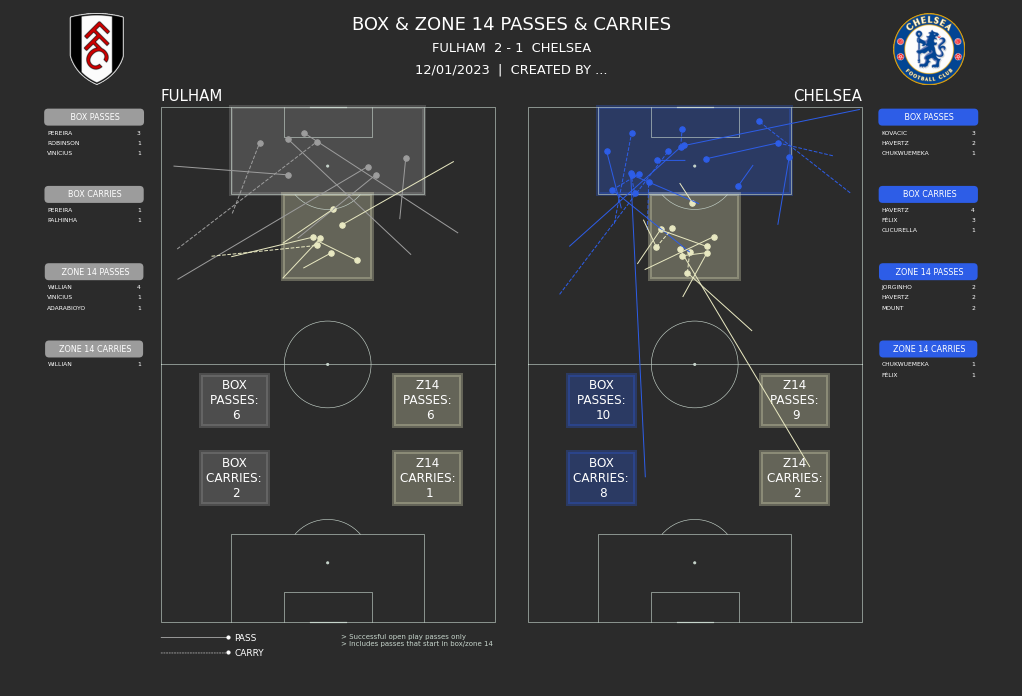

In [16]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.colors


FIGWIDTH, FIGHEIGHT = 14, 10
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
FIG_ASPECT = FIGWIDTH / FIGHEIGHT
fig = plt.figure(figsize=FIGSIZE)
mpl.rcParams['figure.dpi'] = 800

norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#2B2B2B",home_color])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#2B2B2B",away_color])



pitch1 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_left = 40,
                       line_zorder=2, pad_bottom=20, pad_right=5,   linewidth=0.6, pitch_length=5, pad_top=30)
pitch2 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_right = 40,
                       line_zorder=2,  pad_bottom=20, pad_left=5,  linewidth=0.6, pitch_length=5, pad_top=30)

fig.set_facecolor("#2B2B2B")

TITLE_HEIGHT = 0.1 # title axes are 10% of the figure height

#  width of pitch axes as percent of the figure width
TOP_WIDTH = 0.48
BOTTOM_WIDTH = 0.25

# calculate the horizontal space between axes (and figure sides) in percent of the figure width
TOP_SPACE = (1 - (TOP_WIDTH * 2)) / 2
BOTTOM_SPACE = (1 - (BOTTOM_WIDTH * 3)) / 2

# calculate the height of the pitch axes in percent of the figure height
height1 = (TOP_WIDTH / pitch1.ax_aspect * FIG_ASPECT)
height2 = (TOP_WIDTH / pitch2.ax_aspect * FIG_ASPECT)


# calculate pitch offsets from center / title locations
vertical_axes_space = (1 - (height1 + TITLE_HEIGHT + TITLE_HEIGHT)) / 5
bottom_offset = ((1 - height2) / 2) - vertical_axes_space
title1_bottom = 1 - vertical_axes_space - TITLE_HEIGHT
title2_bottom = 1 - (vertical_axes_space * 3) - (TITLE_HEIGHT * 2) - height1
top_offset = (1 - title1_bottom - title2_bottom - TITLE_HEIGHT) / 2



# top left
LEFT1 = TOP_SPACE
bottom1 = (1 - height1) / 2 - top_offset
ax1 = fig.add_axes((LEFT1, bottom1, TOP_WIDTH, height1))
pitch1.draw(ax=ax1)

# top right
left2 = (TOP_SPACE ) + (TOP_WIDTH)
bottom2 = (1 - height2) / 2 - top_offset
ax2 = fig.add_axes((left2, bottom2, TOP_WIDTH, height2))
pitch2.draw(ax=ax2)

ax_title2 = fig.add_axes((0, title1_bottom-0.05, 1, TITLE_HEIGHT-0.05))
ax_title2.axis('off')
ax_title2.text(left2 ,0.45,
               f'{home_name} {score} { away_name}'.upper(),
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,1.1,
               'Box & Zone 14 Passes & Carries'.upper(),
               color='white', size=18, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,-0.15,
               f'{date_str}  |  CREATED BY ...',
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')


pitch1.annotate(text=home_name.upper(), 
                          xytext=(102, 100), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax1)

pitch2.annotate(text=away_name.upper(), 
                          xytext=(102, 0), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax2)

box1 = patches.Rectangle((21.1, 83), 57.8, 17, linewidth=4, edgecolor=home_color, facecolor=home_color, alpha=0.3)
ax1.add_patch(box1)
box2 = patches.Rectangle((21.1, 83), 57.8, 17, linewidth=4, edgecolor=away_color, facecolor=away_color, alpha=0.3)
ax2.add_patch(box2)

z14_1 = patches.Rectangle((36.8, 66.5), 26.7, 16.5, linewidth=4, edgecolor='#E8E8C1', 
                          facecolor='#E8E8C1', alpha=0.3)
ax1.add_patch(z14_1)
z14_2 = patches.Rectangle((36.8, 66.5), 26.7, 16.5, linewidth=4, edgecolor='#E8E8C1', 
                          facecolor='#E8E8C1', alpha=0.3)
ax2.add_patch(z14_2)


z14_h = patches.Rectangle((68, 38), 20, 10, linewidth=4, edgecolor=home_color, 
                          facecolor=home_color, alpha=0.3)
ax1.add_patch(z14_h)
pitch1.annotate(text='Box \nPasses: \n'.upper() + str(box_passes_h_count), 
                          xytext=(43, 77.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax1)


z14_h2 = patches.Rectangle((68, 23), 20, 10, linewidth=4, edgecolor=home_color, 
                          facecolor=home_color, alpha=0.3)
ax1.add_patch(z14_h2)
pitch1.annotate(text='Box \nCarries: \n'.upper() + str(box_carries_h_count), 
                          xytext=(28, 77.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax1)

z14_a = patches.Rectangle((68, 38), 20, 10, linewidth=4, edgecolor=away_color, 
                          facecolor=away_color, alpha=0.3)
ax2.add_patch(z14_a)
pitch2.annotate(text='Box \nPasses: \n'.upper() + str(box_passes_a_count), 
                          xytext=(43, 77.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax2)

z14_a2 = patches.Rectangle((68, 23), 20, 10, linewidth=4, edgecolor=away_color, 
                          facecolor=away_color, alpha=0.3)
ax2.add_patch(z14_a2)
pitch2.annotate(text='Box \nCarries: \n'.upper() + str(box_carries_a_count), 
                          xytext=(28, 77.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax2)

z14_h3 = patches.Rectangle((10, 38), 20, 10, linewidth=4, edgecolor='#E8E8C1', 
                          facecolor='#E8E8C1', alpha=0.3)
ax1.add_patch(z14_h3)
pitch1.annotate(text='Z14 \nPasses: \n'.upper() + str(z14_passes_h_count), 
                          xytext=(43, 19.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax1)

z14_h3 = patches.Rectangle((10, 23), 20, 10, linewidth=4, edgecolor='#E8E8C1', 
                          facecolor='#E8E8C1', alpha=0.3)
ax1.add_patch(z14_h3)
pitch1.annotate(text='Z14 \nCarries: \n'.upper() + str(z14_carries_h_count), 
                          xytext=(28, 19.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax1)

z14_a3 = patches.Rectangle((10, 38), 20, 10, linewidth=4, edgecolor='#E8E8C1', 
                          facecolor='#E8E8C1', alpha=0.3)
ax2.add_patch(z14_a3)
pitch2.annotate(text='Z14 \nPasses: \n'.upper() + str(z14_passes_a_count), 
                          xytext=(43, 19.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax2)


z14_a4 = patches.Rectangle((10, 23), 20, 10, linewidth=4, edgecolor='#E8E8C1', 
                          facecolor='#E8E8C1', alpha=0.3)
ax2.add_patch(z14_a4)
pitch2.annotate(text='Z14 \nCarries: \n'.upper() + str(z14_carries_a_count), 
                          xytext=(28, 19.5), xy=(20, 40), ha='center', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 12, ax = ax2)



box_passesh = pitch1.lines(box_passes_h.x, box_passes_h.y,
                           box_passes_h.endX, box_passes_h.endY, lw=1,
                           color=home_color, zorder=4, ax=ax1)
box_nodesh = pitch1.scatter(box_passes_h.endX, box_passes_h.endY, s=30,
                            color=home_color, linewidth=1, zorder=3, ax=ax1)

box_carriesh = pitch1.lines(box_carries_h.x, box_carries_h.y,
                           box_carries_h.endX, box_carries_h.endY, lw=1,
                           color=home_color, zorder=4, ax=ax1, linestyle='--')
box_nodesh2 = pitch1.scatter(box_carries_h.endX, box_carries_h.endY, s=30,
                            color=home_color, linewidth=1, zorder=3, ax=ax1)

z14_passesh = pitch1.lines(z14_passes_h.x, z14_passes_h.y,
                           z14_passes_h.endX, z14_passes_h.endY, lw=1,
                           color='#E8E8C1', zorder=4, ax=ax1)
z14_nodesh = pitch1.scatter(z14_passes_h.endX, z14_passes_h.endY, s=30,
                            color='#E8E8C1', linewidth=1, zorder=3, ax=ax1)

z14_carriesh = pitch1.lines(z14_carries_h.x, z14_carries_h.y,
                           z14_carries_h.endX, z14_carries_h.endY, lw=1,
                           color='#E8E8C1', zorder=4, ax=ax1, linestyle='--')
z14_nodesh2 = pitch1.scatter(z14_carries_h.endX, z14_carries_h.endY, s=30,
                            color='#E8E8C1', linewidth=1, zorder=3, ax=ax1)


box_passesa = pitch2.lines(box_passes_a.x, box_passes_a.y,
                           box_passes_a.endX, box_passes_a.endY, lw=1,
                           color=away_color, zorder=4, ax=ax2)
box_nodesa = pitch2.scatter(box_passes_a.endX, box_passes_a.endY, s=30,
                            color=away_color, linewidth=1, zorder=3, ax=ax2)

box_carriesa = pitch2.lines(box_carries_a.x, box_carries_a.y,
                           box_carries_a.endX, box_carries_a.endY, lw=1,
                           color=away_color, zorder=4, ax=ax2, linestyle='--')
box_nodesa2 = pitch2.scatter(box_carries_a.endX, box_carries_a.endY, s=30,
                            color=away_color, linewidth=1, zorder=3, ax=ax2)

z14_passesa = pitch2.lines(z14_passes_a.x, z14_passes_a.y,
                           z14_passes_a.endX, z14_passes_a.endY, lw=1,
                           color='#E8E8C1', zorder=4, ax=ax2)
z14_nodesa = pitch2.scatter(z14_passes_a.endX, z14_passes_a.endY, s=30,
                            color='#E8E8C1', linewidth=1, zorder=3, ax=ax2)

z14_carriesa = pitch2.lines(z14_carries_a.x, z14_carries_a.y,
                           z14_carries_a.endX, z14_carries_a.endY, lw=1,
                           color='#E8E8C1', zorder=4, ax=ax2, linestyle='--')
z14_nodesa2 = pitch2.scatter(z14_carries_a.endX, z14_carries_a.endY, s=30,
                            color='#E8E8C1', linewidth=1, zorder=3, ax=ax2)


pitch1.annotate(xytext=(-3.5, 46),xy = (20,40),
                text = '> Successful open play passes only \n> Includes passes that start in box/zone 14',
                color='#c7d5cc',
                va='center', ha='left', fontsize=7, fontname = 'Sans Serif', ax=ax1)



pitch1.annotate(text='         Box Passes        '.upper(), xytext=(98, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)

y = 95
i = 0
for p1, cnt in zip(box_passes_h_top3['playerName'], box_passes_h_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1


pitch1.annotate(text='        Box Carries       '.upper(), xytext=(83, 120), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)

y = 80
i = 0
for p1, cnt in zip(box_carries_h_top3['playerName'], box_carries_h_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1

pitch1.annotate(text='     Zone 14 Passes    '.upper(), xytext=(68, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)
y = 65
i = 0
for p1, cnt in zip(z14_passes_h_top3['playerName'], z14_passes_h_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=str(cnt), 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1

pitch1.annotate(text='    Zone 14 Carries   '.upper(), xytext=(53, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)
y = 50
i = 0
for p1, cnt in zip(z14_carries_h_top3['playerName'], z14_carries_h_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i,106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    i+=1

pitch2.annotate(text='         Box Passes        '.upper(), xytext=(98, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)

y = 95
i = 0
for p1, cnt in zip(box_passes_a_top3['playerName'], box_passes_a_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1



pitch2.annotate(text='        Box Carries       '.upper(), xytext=(83, -20), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)

y = 80
i = 0
for p1, cnt in zip(box_carries_a_top3['playerName'], box_carries_a_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1

pitch2.annotate(text='     Zone 14 Passes    '.upper(), xytext=(68, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)
y = 65
i = 0
for p1, cnt in zip(z14_passes_a_top3['playerName'], z14_passes_a_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=str(cnt), 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1

pitch2.annotate(text='    Zone 14 Carries   '.upper(), xytext=(53, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)
y = 50
i = 0
for p1, cnt in zip(z14_carries_a_top3['playerName'], z14_carries_a_top3['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i,-34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1
    
    
    
    
pitch1.lines(-3, 100, -3, 80, lw=0.5, color='white', zorder=1, ax=ax1)
pitch1.annotate(text='Pass'.upper(), 
                          xytext=(-3, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 9, ax = ax1)
pitch1.scatter(-2.85, 80, s=10, color='white', zorder=1, ax=ax1)

pitch1.lines(-6, 100, -6, 80, lw=0.5, color='white', zorder=1, linestyle='--', ax=ax1)
pitch1.annotate(text='Carry'.upper(), 
                          xytext=(-6, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 9, ax = ax1)
pitch1.scatter(-5.85, 80, s=10, color='white', zorder=1, ax=ax1)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos2 = 9879
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.025, 0.85, 0.1, 0.1], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos = 8455
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
newax = fig.add_axes([0.85, 0.85, 0.1, 0.1], anchor='NE', zorder=2)
newax.imshow(club_icon)
newax.axis('off')



fig.savefig('BoxZ14_PC.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=300)